In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

In [5]:
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

batch_size = 64
epoch_length = len(train_dataset) / batch_size
train_dataset_augmented = kaggle.augment_dataset(train_dataset, batch_size)

type_of_model = 'model4'

### ResNet (custom)

In [29]:
class ResNet(kt.HyperModel):
    def residual_module(self, input, filters, stride=1, bottleneck=0, l2_reg=0.0001, batch_norm=0.99):
        # Applies bottleneck if necessary, to reduce dimensions
        if bottleneck > 0:
            conv_0 = layers.Conv2D(
                bottleneck, kernel_size=(1,1),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            bottleneck = filters
            conv_0 = input

        # Applies relu convolution, then linear convolution before shortcut
        conv_1 = layers.Conv2D(
            bottleneck, kernel_size=(3,3), strides=(stride, stride),
            padding='same', activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_0)
        conv_2 = layers.Conv2D(
            filters, kernel_size=(3,3), 
            padding='same', activation='linear',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(conv_1)
        
        # Ensures shortcut is correct depth by adding a 1x1 convolution
        if input.shape[-1] != filters:
            shortcut = layers.Conv2D(
                filters, kernel_size=(1,1), strides=(stride,stride),
                padding='same', activation='relu',
                kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
                kernel_initializer='he_normal')(input)
        else:
            shortcut = input

        # Adds shortcut
        addition = layers.add([conv_2, shortcut])

        # Batch Norm is performed in the original paper
        if batch_norm >= 0:
            addition = layers.BatchNormalization(momentum=batch_norm)(addition)

        activation = layers.Activation('relu')(addition)
        return activation

    def conv_layer(self, input, filters, kernel, stride, l2_reg=0.0001):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding='same', activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_normal')(input)

    def dense_layer(self, input, size, l2_reg, dropout):
        dense = layers.Dense(
            size, activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg))(input)
        return layers.Dropout(dropout)(dense)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None:
            spatial_dropout = hyperparameters.Float('spatial_dropout', 0.0, 0.6, step=0.1)
            dense_l2_reg = hyperparameters.Float('dense_l2_reg', 0.001, 0.1, step=0.001, sampling='log')
        else:
            spatial_dropout = 0.3 # Not in original paper
            dense_l2_reg = 0.01

        # Fixed hyperparameters
        dense_dropout = 0.7 # Not in original paper
        conv_dropout = 0.3 # Not in original paper
        learning_rate = 0.0001

        input_layer = layers.Input(shape=(96, 96, 1))

        # ResNet, conv1 (input)
        output = self.conv_layer(input_layer, 64, 7, 2)

        # ResNet, conv2
        output = self.residual_module(output, 64)
        output = layers.SpatialDropout2D(spatial_dropout)(output)
        output = self.residual_module(output, 64)

        # ResNet, conv3
        output = self.residual_module(output, 128, 2)
        output = layers.SpatialDropout2D(spatial_dropout)(output)
        output = self.residual_module(output, 128)

        # ResNet, conv4
        output = self.residual_module(output, 256, 2)
        output = layers.Dropout(conv_dropout)(output)
        output = self.residual_module(output, 256)
        
        # ResNet, conv5
        output = self.residual_module(output, 512, 2)
        output = layers.Dropout(conv_dropout)(output)
        output = self.residual_module(output, 512)

        # Final output
        output = layers.GlobalAveragePooling2D()(output)
        output = layers.Dropout(dense_dropout)(output)
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(0.0001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

ResNet().build(None).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 48, 48, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 48, 48, 64)   36928       ['conv2d_20[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 48, 48, 64)   36928       ['conv2d_21[0][0]']              
                                                                                            

In [ ]:
# Hyperparameter tuning
# Use RandomSearch to check Choice params, or Bayesian for Float/Ints

reload_tuner = False
tuner_filepath = 'hypertuner_2021-11-26'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

tuner = kt.BayesianOptimization(ResNet(),
    objective='val_accuracy',
    max_trials=7,
    seed=1,
    directory=f'models/{type_of_model}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

# tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=25, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# best_model = tuner.get_best_models(1)[0]

In [ ]:
# Load existing model if wanted, otherwise create new
use_existing_model = True
model_name = 'resnet_0'
if use_existing_model:
    print("Loading existing model")
    model = keras.models.load_model(f'models/{type_of_model}/{model_name}')
    model.compile(
            optimizer=keras.optimizers.Nadam(0.00001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
else:
    print("Creating new model")
    model = ResNet().build(None)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Fit model (can continue from loaded weights)
history = model.fit(
    train_dataset_augmented, 
    validation_data=valid_dataset.batch(128).cache(),
    epochs=100, steps_per_epoch=epoch_length,
    callbacks=callbacks, verbose=1)

INFO:tensorflow:Assets written to: resnet_0\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


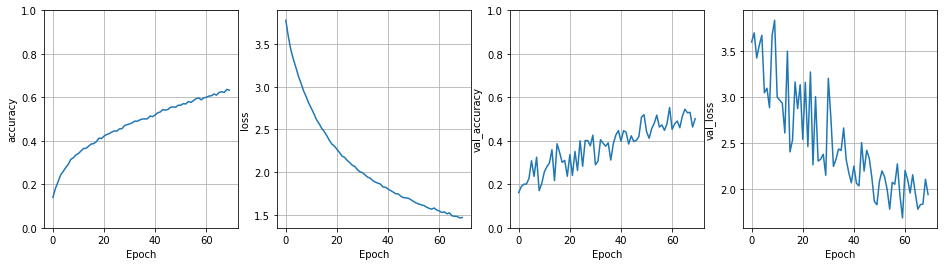

In [36]:
# Save model
model.save(f'models/{type_of_model}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Evaluate model

Accuracy: 0.5017


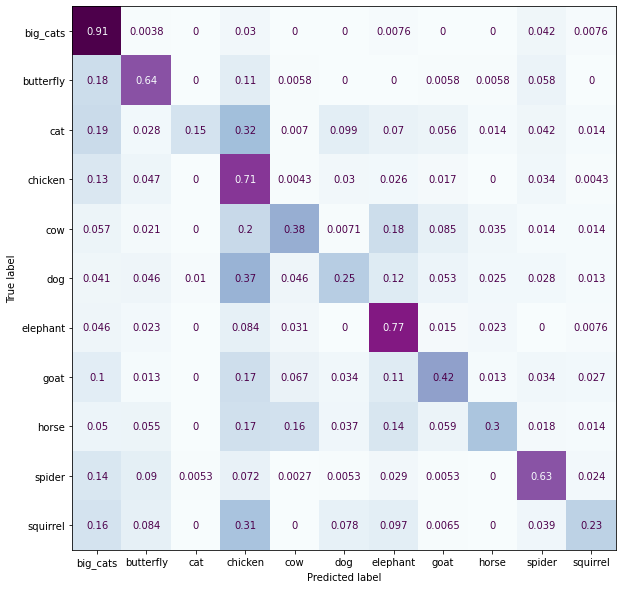

In [38]:
model_to_evaluate = model_name # Can be changed to evaluate older models
model = keras.models.load_model(f'models/model4/{model_to_evaluate}')

test_pred_raw = model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)

### Get labels for Kaggle

In [ ]:
true_test_pred = np.argmax(model.predict(x_test_real), axis=1)

kaggle.save_test_pred(f'models/{type_of_model}/{model_name}_test_pred.csv', true_test_pred)